In [ ]:
# ====== pipsas =======

# implementación
import gymnasium as gym 
import ale_py         
import torch                    
import torch.nn as nn           
import torch.optim as optim     
import numpy as np             
from torch.distributions import Categorical
from torchvision import transforms 

# graficas
import matplotlib.pyplot as plt     

# guardar y cargar 
import os  

In [ ]:
# ====== max rendimiento ======

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# ====== actor critico compartido ======

class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.fc = nn.Linear(state_dim, 64)
        self.policy_head = nn.Linear(64, action_dim)
        self.value_head = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc(x))
        action_probs = torch.softmax(self.policy_head(x), dim=-1)
        state_value = self.value_head(x)
        return action_probs, state_value

In [ ]:
# ====== Retorno ======

def compute_returns(rewards, dones, values, gamma=0.99):
    returns, G = [], 0
    for r, done, v in zip(reversed(rewards), reversed(dones), reversed(values)):
        G = r + gamma * G * (1 - done)
        returns.insert(0, G)
    returns = torch.tensor(returns, dtype=torch.float32).to(device)
    advantages = returns - values
    return returns, advantages

In [ ]:
# ====== entrenamiento ======

env = gym.make('CartPole-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
model = ActorCritic(state_dim, action_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4)

In [ ]:
# ====== datos del entrenamiento ======

clip_eps = 0.2
epochs = 200
ppo_epochs = 4
batch_size = 2048
gamma = 0.99
entropy_coef = 0.01
rewards_history = []

In [ ]:
# ====== implementación del entrenamiento ======

for ep in range(epochs):
    states, actions, rewards, dones, log_probs, values = [], [], [], [], [], []
    obs, _ = env.reset()
    done = False
    episode_rewards = []
    score = 0

    # === Recolecta batch ===
    while len(states) < batch_size:
        state_tensor = torch.FloatTensor(obs).unsqueeze(0).to(device)
        action_probs, value = model(state_tensor)
        dist = Categorical(action_probs)
        action = dist.sample()

        next_obs, reward, terminated, truncated, _ = env.step(action.item())
        done = terminated or truncated

        states.append(obs)
        actions.append(action.item())
        rewards.append(reward)
        dones.append(float(done))
        log_probs.append(dist.log_prob(action).item())
        values.append(value.item())

        obs = next_obs
        score += reward
        if done:
            episode_rewards.append(score) 
            score = 0
            obs, _ = env.reset()

    rewards_history.append(score)

    values_tensor = torch.tensor(values, dtype=torch.float32).to(device)
    returns, advantages = compute_returns(rewards, dones, values_tensor, gamma)
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    states_tensor = torch.FloatTensor(np.stack(states)).to(device)
    actions_tensor = torch.LongTensor(actions).to(device)
    old_log_probs_tensor = torch.FloatTensor(log_probs).to(device)

    # === Actualización PPO ===
    for _ in range(ppo_epochs):
        action_probs, state_values = model(states_tensor)
        dist = Categorical(action_probs)
        new_log_probs = dist.log_prob(actions_tensor)
        ratios = torch.exp(new_log_probs - old_log_probs_tensor)

        surr1 = ratios * advantages
        surr2 = torch.clamp(ratios, 1 - clip_eps, 1 + clip_eps) * advantages
        actor_loss = -torch.min(surr1, surr2).mean()
        critic_loss = (state_values.squeeze() - returns).pow(2).mean()
        entropy = dist.entropy().mean()
        loss = actor_loss + 0.5 * critic_loss - entropy_coef * entropy

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Episodio {ep+1}, Recompensa: {score}")

env.close()

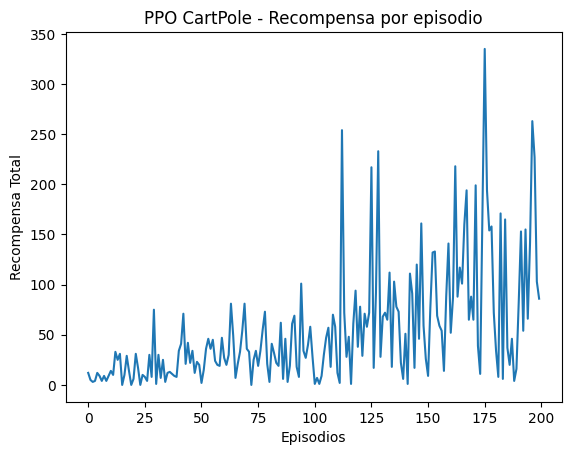

In [3]:
# === Graficar ===
plt.plot(rewards_history)
plt.xlabel('Episodios')
plt.ylabel('Recompensa Total')
plt.title('PPO CartPole - Recompensa por episodio')
plt.show()